In [1]:
import cv2
import numpy as np
import pandas as pd
import pickle
import xgboost as xgb
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
import skimage
#%matplotlib inline
%pylab inline
import os
import sys
from time import time
from glob import glob
sys.path.append(os.environ['REPO_DIR'])
from extractPatches import patch_extractor
from lib.utils import configuration, run

Populating the interactive namespace from numpy and matplotlib


In [2]:
def CDF(x):
    x=np.sort(x)
    size=x.shape[0]
    y=np.arange(0,size)/size
    return x,y

In [3]:
def setup_download_from_s3(rel_fp, recursive=True):
    s3_fp = 's3://mousebrainatlas-data/' + rel_fp
    local_fp = os.environ['ROOT_DIR'] + rel_fp

    if os.path.exists(local_fp):
        print('ALREADY DOWNLOADED FILE')
        return

    if recursive:
        run('aws s3 cp --recursive {0} {1}'.format(s3_fp, local_fp))
    else:
        run('aws s3 cp {0} {1}'.format(s3_fp, local_fp))
        
def setup_upload_from_s3(rel_fp, recursive=True):
    s3_fp = 's3://mousebrainatlas-data/' + rel_fp
    local_fp = os.environ['ROOT_DIR'] + rel_fp

    if recursive:
        run('aws s3 cp --recursive {0} {1}'.format(local_fp, s3_fp))
    else:
        run('aws s3 cp {0} {1}'.format(local_fp, s3_fp))

In [4]:
def features_extractor(tile, params, extractor, threshold):
    if params['preprocessing']['polarity']==-1:
        tile = 255-tile
    min_std=params['preprocessing']['min_std']
    _std = np.std(tile.flatten())

    extracted = []
    if _std < min_std:
        extracted.append([0] * 1981)
    else:
        Stats = extractor.segment_cells(tile)
        cells = extractor.extract_blobs(Stats,tile)
        cells = pd.DataFrame(cells)
        cells = cells[cells['padded_patch'].notnull()]
        cells = cells.drop(['padded_patch','left','top'],1)
        cells = np.asarray(cells)
        for k in range(len(cells)):
            cells[k][0] = cells[k][0][:10]
        origin = np.concatenate((np.array(list(cells[:,0])),cells[:,1:]),axis=1)
        for k in range(origin.shape[1]):
            x, y = CDF(origin[:,k])
            ten = [y[np.argmin(np.absolute(x-threshold[k][j]))] for j in range(99)]
            extracted.extend(ten)
        extracted.extend([cells.shape[0]])
    return extracted

In [5]:
stack = 'MD594'
fp = os.path.join('CSHL_data_processed', stack, stack + '_sorted_filenames.txt')
setup_download_from_s3(fp, recursive=False)
with open(os.environ['ROOT_DIR']+fp, 'r') as f:
    fn_idx_tuples = [line.strip().split() for line in f.readlines()]
    section_to_filename = {int(idx): fn for fn, idx in fn_idx_tuples}

fn = 'CSHL_data_processed/MD589/ThresholdsV2.pkl'
setup_download_from_s3(fn, recursive=False)
thresholds = pickle.load(open(os.environ['ROOT_DIR']+fn,'rb'))

fname = os.path.join('CSHL_data_processed', stack, 'Annotation.npy')
setup_download_from_s3(fname, recursive=False)
annotation = np.load(os.environ['ROOT_DIR']+fname, allow_pickle = True, encoding='latin1')
contours = pd.DataFrame(annotation)
contours = contours.rename(columns={0:"name", 1:"section", 2:"vertices"})
contours_grouped = contours.groupby('section')

ALREADY DOWNLOADED FILE
ALREADY DOWNLOADED FILE
ALREADY DOWNLOADED FILE


In [6]:
#Parameters
param = {}
param['max_depth']= 3   # depth of tree
param['eta'] = 0.2      # shrinkage parameter
param['silent'] = 1     # not silent
param['objective'] = 'binary:logistic' #'multi:softmax'
param['nthread'] = 7 # Number of threads used
param['num_class']=1
num_round = 100

In [27]:
yamlfile=os.environ['REPO_DIR']+'shape_params.yaml'
params=configuration(yamlfile).getParams()

cell_dir = os.environ['ROOT_DIR'] + 'CSHL_patch_samples_features_V2/MD589/'
cell2_dir = os.environ['ROOT_DIR'] + 'CSHL_patch_samples_features_V2/MD585/'
raw_images_root = 'CSHL_data_processed/'+stack+'/'+stack+'_prep2_lossless_gray/'
features_fn = 'CSHL_grid_features/'
if not os.path.exists(os.environ['ROOT_DIR']+features_fn):
    os.mkdir(os.environ['ROOT_DIR']+features_fn)
features_fn = features_fn+stack+'/'
if not os.path.exists(os.environ['ROOT_DIR']+features_fn):
    os.mkdir(os.environ['ROOT_DIR']+features_fn)

savepath = 'CSHL_scoremaps_new/'
if not os.path.exists(os.environ['ROOT_DIR']+savepath):
    os.mkdir(os.environ['ROOT_DIR']+savepath)
savepath = savepath+stack+'/'
if not os.path.exists(os.environ['ROOT_DIR']+savepath):
    os.mkdir(os.environ['ROOT_DIR']+savepath)

paired_structures = ['5N', '6N', '7N', '7nn', 'Amb', 'LC', 'LRt', 'Pn', 'Tz', 'VLL', 'RMC', \
                     'SNC', 'SNR', '3N', '4N', 'Sp5I', 'Sp5O', 'Sp5C', 'PBG', '10N', 'VCA', 'VCP', 'DC']
singular_structures = ['AP', '12N', 'RtTg', 'SC', 'IC']

all_structures = paired_structures + singular_structures
window_size = 224

In [8]:
%%time
section = 200
img_fn = raw_images_root + section_to_filename[section] + '_prep2_lossless_gray.tif'
setup_download_from_s3(img_fn, recursive=False)
img = cv2.imread(os.environ['ROOT_DIR']+img_fn, 2)
m, n = img.shape
extractor = patch_extractor(params)

ALREADY DOWNLOADED FILE
CPU times: user 766 ms, sys: 799 ms, total: 1.57 s
Wall time: 2.3 s


In [15]:
%%time
half_size = int(window_size/2)
polygons = [(contour['name'], contour['vertices']) \
                for contour_id, contour in contours_grouped.get_group(section).iterrows()]
xs, ys = np.meshgrid(np.arange(0, n, half_size), np.arange(0, m, half_size), indexing='xy')
locations = np.c_[xs.flat, ys.flat]
valid_structure = {}
for contour_id, contour in polygons:
    valid_structure[contour_id] = contour

CPU times: user 2.48 ms, sys: 374 µs, total: 2.86 ms
Wall time: 2.58 ms


In [19]:
valid_structure.keys()

dict_keys(['SC', 'Pn', 'Sp5C', 'IO', 'Tz', 'VTA', 'RtTg', '7n', 'RMC', 'IC'])

In [10]:
len(locations)

15400

In [11]:
%%time
grid_features = {}
for i in range(len(locations)):
    print(i, len(locations))
    left = locations[i][0]
    right = int(min(left + window_size, n))
    up = locations[i][1]
    down = int(min(up + window_size, m))
    tile = img[up:down, left:right]
    grid_index = str(section)+'_'+str(left)+'_'+str(up)
    try:
        extracted = features_extractor(tile, params, extractor, thresholds)
        grid_features[grid_index] = extracted
    except:
        continue

0 15400
1 15400
2 15400
3 15400
4 15400
5 15400
6 15400
7 15400
8 15400
9 15400
10 15400
11 15400
12 15400
13 15400
14 15400
15 15400
16 15400
17 15400
18 15400
19 15400
20 15400
21 15400
22 15400
23 15400
24 15400
25 15400
26 15400
27 15400
28 15400
29 15400
30 15400
31 15400
32 15400
33 15400
34 15400
35 15400
36 15400
37 15400
38 15400
39 15400
40 15400
41 15400
42 15400
43 15400
44 15400
45 15400
46 15400
47 15400
48 15400
49 15400
50 15400
51 15400
52 15400
53 15400
54 15400
55 15400
56 15400
57 15400
58 15400
59 15400
60 15400
61 15400
62 15400
63 15400
64 15400
65 15400
66 15400
67 15400
68 15400
69 15400
70 15400
71 15400
72 15400
73 15400
74 15400
75 15400
76 15400
77 15400
78 15400
79 15400
80 15400
81 15400
82 15400
83 15400
84 15400
85 15400
86 15400
87 15400
88 15400
89 15400
90 15400
91 15400
92 15400
93 15400
94 15400
95 15400
96 15400
97 15400
98 15400
99 15400
100 15400
101 15400
102 15400
103 15400
104 15400
105 15400
106 15400
107 15400
108 15400
109 15400
110 15400


831 15400
832 15400
833 15400
834 15400
835 15400
836 15400
837 15400
838 15400
839 15400
840 15400
841 15400
842 15400
843 15400
844 15400
845 15400
846 15400
847 15400
848 15400
849 15400
850 15400
851 15400
852 15400
853 15400
854 15400
855 15400
856 15400
857 15400
858 15400
859 15400
860 15400
861 15400
862 15400
863 15400
864 15400
865 15400
866 15400
867 15400
868 15400
869 15400
870 15400
871 15400
872 15400
873 15400
874 15400
875 15400
876 15400
877 15400
878 15400
879 15400
880 15400
881 15400
882 15400
883 15400
884 15400
885 15400
886 15400
887 15400
888 15400
889 15400
890 15400
891 15400
892 15400
893 15400
894 15400
895 15400
896 15400
897 15400
898 15400
899 15400
900 15400
901 15400
902 15400
903 15400
904 15400
905 15400
906 15400
907 15400
908 15400
909 15400
910 15400
911 15400
912 15400
913 15400
914 15400
915 15400
916 15400
917 15400
918 15400
919 15400
920 15400
921 15400
922 15400
923 15400
924 15400
925 15400
926 15400
927 15400
928 15400
929 15400
930 15400


1592 15400
1593 15400
1594 15400
1595 15400
1596 15400
1597 15400
1598 15400
1599 15400
1600 15400
1601 15400
1602 15400
1603 15400
1604 15400
1605 15400
1606 15400
1607 15400
1608 15400
1609 15400
1610 15400
1611 15400
1612 15400
1613 15400
1614 15400
1615 15400
1616 15400
1617 15400
1618 15400
1619 15400
1620 15400
1621 15400
1622 15400
1623 15400
1624 15400
1625 15400
1626 15400
1627 15400
1628 15400
1629 15400
1630 15400
1631 15400
1632 15400
1633 15400
1634 15400
1635 15400
1636 15400
1637 15400
1638 15400
1639 15400
1640 15400
1641 15400
1642 15400
1643 15400
1644 15400
1645 15400
1646 15400
1647 15400
1648 15400
1649 15400
1650 15400
1651 15400
1652 15400
1653 15400
1654 15400
1655 15400
1656 15400
1657 15400
1658 15400
1659 15400
1660 15400
1661 15400
1662 15400
1663 15400
1664 15400
1665 15400
1666 15400
1667 15400
1668 15400
1669 15400
1670 15400
1671 15400
1672 15400
1673 15400
1674 15400
1675 15400
1676 15400
1677 15400
1678 15400
1679 15400
1680 15400
1681 15400
1682 15400

2337 15400
2338 15400
2339 15400
2340 15400
2341 15400
2342 15400
2343 15400
2344 15400
2345 15400
2346 15400
2347 15400
2348 15400
2349 15400
2350 15400
2351 15400
2352 15400
2353 15400
2354 15400
2355 15400
2356 15400
2357 15400
2358 15400
2359 15400
2360 15400
2361 15400
2362 15400
2363 15400
2364 15400
2365 15400
2366 15400
2367 15400
2368 15400
2369 15400
2370 15400
2371 15400
2372 15400
2373 15400
2374 15400
2375 15400
2376 15400
2377 15400
2378 15400
2379 15400
2380 15400
2381 15400
2382 15400
2383 15400
2384 15400
2385 15400
2386 15400
2387 15400
2388 15400
2389 15400
2390 15400
2391 15400
2392 15400
2393 15400
2394 15400
2395 15400
2396 15400
2397 15400
2398 15400
2399 15400
2400 15400
2401 15400
2402 15400
2403 15400
2404 15400
2405 15400
2406 15400
2407 15400
2408 15400
2409 15400
2410 15400
2411 15400
2412 15400
2413 15400
2414 15400
2415 15400
2416 15400
2417 15400
2418 15400
2419 15400
2420 15400
2421 15400
2422 15400
2423 15400
2424 15400
2425 15400
2426 15400
2427 15400

3082 15400
3083 15400
3084 15400
3085 15400
3086 15400
3087 15400
3088 15400
3089 15400
3090 15400
3091 15400
3092 15400
3093 15400
3094 15400
3095 15400
3096 15400
3097 15400
3098 15400
3099 15400
3100 15400
3101 15400
3102 15400
3103 15400
3104 15400
3105 15400
3106 15400
3107 15400
3108 15400
3109 15400
3110 15400
3111 15400
3112 15400
3113 15400
3114 15400
3115 15400
3116 15400
3117 15400
3118 15400
3119 15400
3120 15400
3121 15400
3122 15400
3123 15400
3124 15400
3125 15400
3126 15400
3127 15400
3128 15400
3129 15400
3130 15400
3131 15400
3132 15400
3133 15400
3134 15400
3135 15400
3136 15400
3137 15400
3138 15400
3139 15400
3140 15400
3141 15400
3142 15400
3143 15400
3144 15400
3145 15400
3146 15400
3147 15400
3148 15400
3149 15400
3150 15400
3151 15400
3152 15400
3153 15400
3154 15400
3155 15400
3156 15400
3157 15400
3158 15400
3159 15400
3160 15400
3161 15400
3162 15400
3163 15400
3164 15400
3165 15400
3166 15400
3167 15400
3168 15400
3169 15400
3170 15400
3171 15400
3172 15400

3851 15400
3852 15400
3853 15400
3854 15400
3855 15400
3856 15400
3857 15400
3858 15400
3859 15400
3860 15400
3861 15400
3862 15400
3863 15400
3864 15400
3865 15400
3866 15400
3867 15400
3868 15400
3869 15400
3870 15400
3871 15400
3872 15400
3873 15400
3874 15400
3875 15400
3876 15400
3877 15400
3878 15400
3879 15400
3880 15400
3881 15400
3882 15400
3883 15400
3884 15400
3885 15400
3886 15400
3887 15400
3888 15400
3889 15400
3890 15400
3891 15400
3892 15400
3893 15400
3894 15400
3895 15400
3896 15400
3897 15400
3898 15400
3899 15400
3900 15400
3901 15400
3902 15400
3903 15400
3904 15400
3905 15400
3906 15400
3907 15400
3908 15400
3909 15400
3910 15400
3911 15400
3912 15400
3913 15400
3914 15400
3915 15400
3916 15400
3917 15400
3918 15400
3919 15400
3920 15400
3921 15400
3922 15400
3923 15400
3924 15400
3925 15400
3926 15400
3927 15400
3928 15400
3929 15400
3930 15400
3931 15400
3932 15400
3933 15400
3934 15400
3935 15400
3936 15400
3937 15400
3938 15400
3939 15400
3940 15400
3941 15400

4621 15400
4622 15400
4623 15400
4624 15400
4625 15400
4626 15400
4627 15400
4628 15400
4629 15400
4630 15400
4631 15400
4632 15400
4633 15400
4634 15400
4635 15400
4636 15400
4637 15400
4638 15400
4639 15400
4640 15400
4641 15400
4642 15400
4643 15400
4644 15400
4645 15400
4646 15400
4647 15400
4648 15400
4649 15400
4650 15400
4651 15400
4652 15400
4653 15400
4654 15400
4655 15400
4656 15400
4657 15400
4658 15400
4659 15400
4660 15400
4661 15400
4662 15400
4663 15400
4664 15400
4665 15400
4666 15400
4667 15400
4668 15400
4669 15400
4670 15400
4671 15400
4672 15400
4673 15400
4674 15400
4675 15400
4676 15400
4677 15400
4678 15400
4679 15400
4680 15400
4681 15400
4682 15400
4683 15400
4684 15400
4685 15400
4686 15400
4687 15400
4688 15400
4689 15400
4690 15400
4691 15400
4692 15400
4693 15400
4694 15400
4695 15400
4696 15400
4697 15400
4698 15400
4699 15400
4700 15400
4701 15400
4702 15400
4703 15400
4704 15400
4705 15400
4706 15400
4707 15400
4708 15400
4709 15400
4710 15400
4711 15400

5391 15400
5392 15400
5393 15400
5394 15400
5395 15400
5396 15400
5397 15400
5398 15400
5399 15400
5400 15400
5401 15400
5402 15400
5403 15400
5404 15400
5405 15400
5406 15400
5407 15400
5408 15400
5409 15400
5410 15400
5411 15400
5412 15400
5413 15400
5414 15400
5415 15400
5416 15400
5417 15400
5418 15400
5419 15400
5420 15400
5421 15400
5422 15400
5423 15400
5424 15400
5425 15400
5426 15400
5427 15400
5428 15400
5429 15400
5430 15400
5431 15400
5432 15400
5433 15400
5434 15400
5435 15400
5436 15400
5437 15400
5438 15400
5439 15400
5440 15400
5441 15400
5442 15400
5443 15400
5444 15400
5445 15400
5446 15400
5447 15400
5448 15400
5449 15400
5450 15400
5451 15400
5452 15400
5453 15400
5454 15400
5455 15400
5456 15400
5457 15400
5458 15400
5459 15400
5460 15400
5461 15400
5462 15400
5463 15400
5464 15400
5465 15400
5466 15400
5467 15400
5468 15400
5469 15400
5470 15400
5471 15400
5472 15400
5473 15400
5474 15400
5475 15400
5476 15400
5477 15400
5478 15400
5479 15400
5480 15400
5481 15400

6161 15400
6162 15400
6163 15400
6164 15400
6165 15400
6166 15400
6167 15400
6168 15400
6169 15400
6170 15400
6171 15400
6172 15400
6173 15400
6174 15400
6175 15400
6176 15400
6177 15400
6178 15400
6179 15400
6180 15400
6181 15400
6182 15400
6183 15400
6184 15400
6185 15400
6186 15400
6187 15400
6188 15400
6189 15400
6190 15400
6191 15400
6192 15400
6193 15400
6194 15400
6195 15400
6196 15400
6197 15400
6198 15400
6199 15400
6200 15400
6201 15400
6202 15400
6203 15400
6204 15400
6205 15400
6206 15400
6207 15400
6208 15400
6209 15400
6210 15400
6211 15400
6212 15400
6213 15400
6214 15400
6215 15400
6216 15400
6217 15400
6218 15400
6219 15400
6220 15400
6221 15400
6222 15400
6223 15400
6224 15400
6225 15400
6226 15400
6227 15400
6228 15400
6229 15400
6230 15400
6231 15400
6232 15400
6233 15400
6234 15400
6235 15400
6236 15400
6237 15400
6238 15400
6239 15400
6240 15400
6241 15400
6242 15400
6243 15400
6244 15400
6245 15400
6246 15400
6247 15400
6248 15400
6249 15400
6250 15400
6251 15400

6931 15400
6932 15400
6933 15400
6934 15400
6935 15400
6936 15400
6937 15400
6938 15400
6939 15400
6940 15400
6941 15400
6942 15400
6943 15400
6944 15400
6945 15400
6946 15400
6947 15400
6948 15400
6949 15400
6950 15400
6951 15400
6952 15400
6953 15400
6954 15400
6955 15400
6956 15400
6957 15400
6958 15400
6959 15400
6960 15400
6961 15400
6962 15400
6963 15400
6964 15400
6965 15400
6966 15400
6967 15400
6968 15400
6969 15400
6970 15400
6971 15400
6972 15400
6973 15400
6974 15400
6975 15400
6976 15400
6977 15400
6978 15400
6979 15400
6980 15400
6981 15400
6982 15400
6983 15400
6984 15400
6985 15400
6986 15400
6987 15400
6988 15400
6989 15400
6990 15400
6991 15400
6992 15400
6993 15400
6994 15400
6995 15400
6996 15400
6997 15400
6998 15400
6999 15400
7000 15400
7001 15400
7002 15400
7003 15400
7004 15400
7005 15400
7006 15400
7007 15400
7008 15400
7009 15400
7010 15400
7011 15400
7012 15400
7013 15400
7014 15400
7015 15400
7016 15400
7017 15400
7018 15400
7019 15400
7020 15400
7021 15400

7701 15400
7702 15400
7703 15400
7704 15400
7705 15400
7706 15400
7707 15400
7708 15400
7709 15400
7710 15400
7711 15400
7712 15400
7713 15400
7714 15400
7715 15400
7716 15400
7717 15400
7718 15400
7719 15400
7720 15400
7721 15400
7722 15400
7723 15400
7724 15400
7725 15400
7726 15400
7727 15400
7728 15400
7729 15400
7730 15400
7731 15400
7732 15400
7733 15400
7734 15400
7735 15400
7736 15400
7737 15400
7738 15400
7739 15400
7740 15400
7741 15400
7742 15400
7743 15400
7744 15400
7745 15400
7746 15400
7747 15400
7748 15400
7749 15400
7750 15400
7751 15400
7752 15400
7753 15400
7754 15400
7755 15400
7756 15400
7757 15400
7758 15400
7759 15400
7760 15400
7761 15400
7762 15400
7763 15400
7764 15400
7765 15400
7766 15400
7767 15400
7768 15400
7769 15400
7770 15400
7771 15400
7772 15400
7773 15400
7774 15400
7775 15400
7776 15400
7777 15400
7778 15400
7779 15400
7780 15400
7781 15400
7782 15400
7783 15400
7784 15400
7785 15400
7786 15400
7787 15400
7788 15400
7789 15400
7790 15400
7791 15400

8471 15400
8472 15400
8473 15400
8474 15400
8475 15400
8476 15400
8477 15400
8478 15400
8479 15400
8480 15400
8481 15400
8482 15400
8483 15400
8484 15400
8485 15400
8486 15400
8487 15400
8488 15400
8489 15400
8490 15400
8491 15400
8492 15400
8493 15400
8494 15400
8495 15400
8496 15400
8497 15400
8498 15400
8499 15400
8500 15400
8501 15400
8502 15400
8503 15400
8504 15400
8505 15400
8506 15400
8507 15400
8508 15400
8509 15400
8510 15400
8511 15400
8512 15400
8513 15400
8514 15400
8515 15400
8516 15400
8517 15400
8518 15400
8519 15400
8520 15400
8521 15400
8522 15400
8523 15400
8524 15400
8525 15400
8526 15400
8527 15400
8528 15400
8529 15400
8530 15400
8531 15400
8532 15400
8533 15400
8534 15400
8535 15400
8536 15400
8537 15400
8538 15400
8539 15400
8540 15400
8541 15400
8542 15400
8543 15400
8544 15400
8545 15400
8546 15400
8547 15400
8548 15400
8549 15400
8550 15400
8551 15400
8552 15400
8553 15400
8554 15400
8555 15400
8556 15400
8557 15400
8558 15400
8559 15400
8560 15400
8561 15400

9216 15400
9217 15400
9218 15400
9219 15400
9220 15400
9221 15400
9222 15400
9223 15400
9224 15400
9225 15400
9226 15400
9227 15400
9228 15400
9229 15400
9230 15400
9231 15400
9232 15400
9233 15400
9234 15400
9235 15400
9236 15400
9237 15400
9238 15400
9239 15400
9240 15400
9241 15400
9242 15400
9243 15400
9244 15400
9245 15400
9246 15400
9247 15400
9248 15400
9249 15400
9250 15400
9251 15400
9252 15400
9253 15400
9254 15400
9255 15400
9256 15400
9257 15400
9258 15400
9259 15400
9260 15400
9261 15400
9262 15400
9263 15400
9264 15400
9265 15400
9266 15400
9267 15400
9268 15400
9269 15400
9270 15400
9271 15400
9272 15400
9273 15400
9274 15400
9275 15400
9276 15400
9277 15400
9278 15400
9279 15400
9280 15400
9281 15400
9282 15400
9283 15400
9284 15400
9285 15400
9286 15400
9287 15400
9288 15400
9289 15400
9290 15400
9291 15400
9292 15400
9293 15400
9294 15400
9295 15400
9296 15400
9297 15400
9298 15400
9299 15400
9300 15400
9301 15400
9302 15400
9303 15400
9304 15400
9305 15400
9306 15400

9961 15400
9962 15400
9963 15400
9964 15400
9965 15400
9966 15400
9967 15400
9968 15400
9969 15400
9970 15400
9971 15400
9972 15400
9973 15400
9974 15400
9975 15400
9976 15400
9977 15400
9978 15400
9979 15400
9980 15400
9981 15400
9982 15400
9983 15400
9984 15400
9985 15400
9986 15400
9987 15400
9988 15400
9989 15400
9990 15400
9991 15400
9992 15400
9993 15400
9994 15400
9995 15400
9996 15400
9997 15400
9998 15400
9999 15400
10000 15400
10001 15400
10002 15400
10003 15400
10004 15400
10005 15400
10006 15400
10007 15400
10008 15400
10009 15400
10010 15400
10011 15400
10012 15400
10013 15400
10014 15400
10015 15400
10016 15400
10017 15400
10018 15400
10019 15400
10020 15400
10021 15400
10022 15400
10023 15400
10024 15400
10025 15400
10026 15400
10027 15400
10028 15400
10029 15400
10030 15400
10031 15400
10032 15400
10033 15400
10034 15400
10035 15400
10036 15400
10037 15400
10038 15400
10039 15400
10040 15400
10041 15400
10042 15400
10043 15400
10044 15400
10045 15400
10046 15400
10047 1

10647 15400
10648 15400
10649 15400
10650 15400
10651 15400
10652 15400
10653 15400
10654 15400
10655 15400
10656 15400
10657 15400
10658 15400
10659 15400
10660 15400
10661 15400
10662 15400
10663 15400
10664 15400
10665 15400
10666 15400
10667 15400
10668 15400
10669 15400
10670 15400
10671 15400
10672 15400
10673 15400
10674 15400
10675 15400
10676 15400
10677 15400
10678 15400
10679 15400
10680 15400
10681 15400
10682 15400
10683 15400
10684 15400
10685 15400
10686 15400
10687 15400
10688 15400
10689 15400
10690 15400
10691 15400
10692 15400
10693 15400
10694 15400
10695 15400
10696 15400
10697 15400
10698 15400
10699 15400
10700 15400
10701 15400
10702 15400
10703 15400
10704 15400
10705 15400
10706 15400
10707 15400
10708 15400
10709 15400
10710 15400
10711 15400
10712 15400
10713 15400
10714 15400
10715 15400
10716 15400
10717 15400
10718 15400
10719 15400
10720 15400
10721 15400
10722 15400
10723 15400
10724 15400
10725 15400
10726 15400
10727 15400
10728 15400
10729 15400
1073

11330 15400
11331 15400
11332 15400
11333 15400
11334 15400
11335 15400
11336 15400
11337 15400
11338 15400
11339 15400
11340 15400
11341 15400
11342 15400
11343 15400
11344 15400
11345 15400
11346 15400
11347 15400
11348 15400
11349 15400
11350 15400
11351 15400
11352 15400
11353 15400
11354 15400
11355 15400
11356 15400
11357 15400
11358 15400
11359 15400
11360 15400
11361 15400
11362 15400
11363 15400
11364 15400
11365 15400
11366 15400
11367 15400
11368 15400
11369 15400
11370 15400
11371 15400
11372 15400
11373 15400
11374 15400
11375 15400
11376 15400
11377 15400
11378 15400
11379 15400
11380 15400
11381 15400
11382 15400
11383 15400
11384 15400
11385 15400
11386 15400
11387 15400
11388 15400
11389 15400
11390 15400
11391 15400
11392 15400
11393 15400
11394 15400
11395 15400
11396 15400
11397 15400
11398 15400
11399 15400
11400 15400
11401 15400
11402 15400
11403 15400
11404 15400
11405 15400
11406 15400
11407 15400
11408 15400
11409 15400
11410 15400
11411 15400
11412 15400
1141

12013 15400
12014 15400
12015 15400
12016 15400
12017 15400
12018 15400
12019 15400
12020 15400
12021 15400
12022 15400
12023 15400
12024 15400
12025 15400
12026 15400
12027 15400
12028 15400
12029 15400
12030 15400
12031 15400
12032 15400
12033 15400
12034 15400
12035 15400
12036 15400
12037 15400
12038 15400
12039 15400
12040 15400
12041 15400
12042 15400
12043 15400
12044 15400
12045 15400
12046 15400
12047 15400
12048 15400
12049 15400
12050 15400
12051 15400
12052 15400
12053 15400
12054 15400
12055 15400
12056 15400
12057 15400
12058 15400
12059 15400
12060 15400
12061 15400
12062 15400
12063 15400
12064 15400
12065 15400
12066 15400
12067 15400
12068 15400
12069 15400
12070 15400
12071 15400
12072 15400
12073 15400
12074 15400
12075 15400
12076 15400
12077 15400
12078 15400
12079 15400
12080 15400
12081 15400
12082 15400
12083 15400
12084 15400
12085 15400
12086 15400
12087 15400
12088 15400
12089 15400
12090 15400
12091 15400
12092 15400
12093 15400
12094 15400
12095 15400
1209

12696 15400
12697 15400
12698 15400
12699 15400
12700 15400
12701 15400
12702 15400
12703 15400
12704 15400
12705 15400
12706 15400
12707 15400
12708 15400
12709 15400
12710 15400
12711 15400
12712 15400
12713 15400
12714 15400
12715 15400
12716 15400
12717 15400
12718 15400
12719 15400
12720 15400
12721 15400
12722 15400
12723 15400
12724 15400
12725 15400
12726 15400
12727 15400
12728 15400
12729 15400
12730 15400
12731 15400
12732 15400
12733 15400
12734 15400
12735 15400
12736 15400
12737 15400
12738 15400
12739 15400
12740 15400
12741 15400
12742 15400
12743 15400
12744 15400
12745 15400
12746 15400
12747 15400
12748 15400
12749 15400
12750 15400
12751 15400
12752 15400
12753 15400
12754 15400
12755 15400
12756 15400
12757 15400
12758 15400
12759 15400
12760 15400
12761 15400
12762 15400
12763 15400
12764 15400
12765 15400
12766 15400
12767 15400
12768 15400
12769 15400
12770 15400
12771 15400
12772 15400
12773 15400
12774 15400
12775 15400
12776 15400
12777 15400
12778 15400
1277

13379 15400
13380 15400
13381 15400
13382 15400
13383 15400
13384 15400
13385 15400
13386 15400
13387 15400
13388 15400
13389 15400
13390 15400
13391 15400
13392 15400
13393 15400
13394 15400
13395 15400
13396 15400
13397 15400
13398 15400
13399 15400
13400 15400
13401 15400
13402 15400
13403 15400
13404 15400
13405 15400
13406 15400
13407 15400
13408 15400
13409 15400
13410 15400
13411 15400
13412 15400
13413 15400
13414 15400
13415 15400
13416 15400
13417 15400
13418 15400
13419 15400
13420 15400
13421 15400
13422 15400
13423 15400
13424 15400
13425 15400
13426 15400
13427 15400
13428 15400
13429 15400
13430 15400
13431 15400
13432 15400
13433 15400
13434 15400
13435 15400
13436 15400
13437 15400
13438 15400
13439 15400
13440 15400
13441 15400
13442 15400
13443 15400
13444 15400
13445 15400
13446 15400
13447 15400
13448 15400
13449 15400
13450 15400
13451 15400
13452 15400
13453 15400
13454 15400
13455 15400
13456 15400
13457 15400
13458 15400
13459 15400
13460 15400
13461 15400
1346

14062 15400
14063 15400
14064 15400
14065 15400
14066 15400
14067 15400
14068 15400
14069 15400
14070 15400
14071 15400
14072 15400
14073 15400
14074 15400
14075 15400
14076 15400
14077 15400
14078 15400
14079 15400
14080 15400
14081 15400
14082 15400
14083 15400
14084 15400
14085 15400
14086 15400
14087 15400
14088 15400
14089 15400
14090 15400
14091 15400
14092 15400
14093 15400
14094 15400
14095 15400
14096 15400
14097 15400
14098 15400
14099 15400
14100 15400
14101 15400
14102 15400
14103 15400
14104 15400
14105 15400
14106 15400
14107 15400
14108 15400
14109 15400
14110 15400
14111 15400
14112 15400
14113 15400
14114 15400
14115 15400
14116 15400
14117 15400
14118 15400
14119 15400
14120 15400
14121 15400
14122 15400
14123 15400
14124 15400
14125 15400
14126 15400
14127 15400
14128 15400
14129 15400
14130 15400
14131 15400
14132 15400
14133 15400
14134 15400
14135 15400
14136 15400
14137 15400
14138 15400
14139 15400
14140 15400
14141 15400
14142 15400
14143 15400
14144 15400
1414

14766 15400
14767 15400
14768 15400
14769 15400
14770 15400
14771 15400
14772 15400
14773 15400
14774 15400
14775 15400
14776 15400
14777 15400
14778 15400
14779 15400
14780 15400
14781 15400
14782 15400
14783 15400
14784 15400
14785 15400
14786 15400
14787 15400
14788 15400
14789 15400
14790 15400
14791 15400
14792 15400
14793 15400
14794 15400
14795 15400
14796 15400
14797 15400
14798 15400
14799 15400
14800 15400
14801 15400
14802 15400
14803 15400
14804 15400
14805 15400
14806 15400
14807 15400
14808 15400
14809 15400
14810 15400
14811 15400
14812 15400
14813 15400
14814 15400
14815 15400
14816 15400
14817 15400
14818 15400
14819 15400
14820 15400
14821 15400
14822 15400
14823 15400
14824 15400
14825 15400
14826 15400
14827 15400
14828 15400
14829 15400
14830 15400
14831 15400
14832 15400
14833 15400
14834 15400
14835 15400
14836 15400
14837 15400
14838 15400
14839 15400
14840 15400
14841 15400
14842 15400
14843 15400
14844 15400
14845 15400
14846 15400
14847 15400
14848 15400
1484

In [33]:
%%time
for structure in all_structures:
    if structure not in valid_structure.keys():
        continue
    print(structure)
    subpath = savepath + structure + '/'
    if not os.path.exists(os.environ['ROOT_DIR']+subpath):
        os.mkdir(os.environ['ROOT_DIR']+subpath)
    
    fp =[]
    fp.append(cell_dir+structure+'/MD589_'+structure+'_positive.pkl') 
    fp.append(cell_dir+structure+'/MD589_'+structure+'_negative.pkl') 
    X_train = []
    y_train = []
    for state in range(2):
        clouds = pickle.load(open(fp[state],'rb'))
        X_train.extend(np.array(clouds))
        y_train.extend([1-state]*len(clouds))
    
    fp =[]
    fp.append(cell2_dir+structure+'/MD585_'+structure+'_positive.pkl') 
    fp.append(cell2_dir+structure+'/MD585_'+structure+'_negative.pkl') 
    for state in range(2):
        clouds = pickle.load(open(fp[state],'rb'))
        X_train.extend(np.array(clouds))
        y_train.extend([1-state]*len(clouds))
    X_train = np.array(X_train)
    y_train = np.array(y_train)
    dtrain = xgb.DMatrix(X_train, label=y_train)
    bst = xgb.train(param, dtrain, num_round, verbose_eval=False)

    if structure == '7nn':
        structure = '7n'
    
    scoremap = np.zeros([m,n])
    for x,y in locations:
        try:
            grid_index = str(section)+'_'+str(x)+'_'+str(y)
            feature_vector = grid_features[grid_index]
            xtest = xgb.DMatrix(feature_vector)
            score = bst.predict(xtest, output_margin=True, ntree_limit=bst.best_ntree_limit)
            origin = scoremap[y:y+window_size, x:x+window_size]
            comp = np.absolute(origin) - np.absolute(score)
            scoremap[y:y+window_size, x:x+window_size] = origin * (comp > 0) + score * (comp < 0)
        except:
            continue
    scoremap = 1 / (1+np.exp(-scoremap))
#     scoremap = (scoremap - scoremap.min()) / (scoremap.max() - scoremap.min())
    gray = scoremap * 255
    gray = gray.astype(np.uint8)
    if structure in valid_structure.keys():
        polygon = valid_structure[structure]
        rgb = cv2.cvtColor(gray,cv2.COLOR_GRAY2RGB)
        com = cv2.polylines(rgb.copy(), [polygon.astype(np.int32)], True, [0, 255, 0], 15, lineType=8)
    else:
        com = gray
    filename = subpath + structure + '_' + str(section) + '.tif'
    cv2.imwrite(os.environ['ROOT_DIR']+filename, com)

Pn
Tz
RMC
Sp5C
RtTg
SC
IC
CPU times: user 7min 23s, sys: 56.7 s, total: 8min 20s
Wall time: 6min 55s


In [30]:
a = np.array([[0, 1], [1, 0]])
1/(1+np.exp(-a))

array([[0.5       , 0.73105858],
       [0.73105858, 0.5       ]])

True

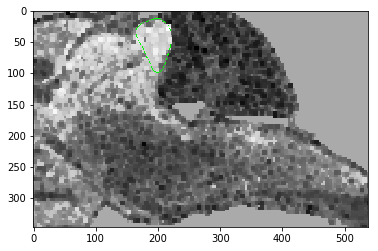

In [55]:
# figure(figsize=[8,8])
com = cv2.polylines(rgb.copy(), [polygon.astype(np.int32)], True, [0, 255, 0], 30, lineType=8)
imshow(com[::32,::32])
cv2.imwrite(os.environ['ROOT_DIR']+filename, com[::32,::32])

In [56]:
len(grid_features.keys())

15354